# Nonlinear Regression with ParmEst

In [1]:
import sys

# If running on Google Colab, install Pyomo and Ipopt via IDAES
on_colab = "google.colab" in sys.modules
if on_colab:
    !wget "https://raw.githubusercontent.com/dowlinglab/pyomo-doe/main/notebooks/tclab_pyomo.py"

# import TCLab model, simulation, and data analysis functions
from tclab_pyomo import (
    TC_Lab_data,
    TC_Lab_experiment,
    extract_results,
    extract_plot_results,
)

# set default number of states in the TCLab model
number_tclab_states = 2

## Load and explore experimental data

In [2]:
import pandas as pd

if on_colab:
    file = "https://raw.githubusercontent.com/dowlinglab/pyomo-doe/main/data/tclab_sine_test_5min_period.csv"
else:
    file = '../data/tclab_sine_test_5min_period.csv'
df = pd.read_csv(file)
df.head()

,Time,T1,T2,Q1,Q2
0,0.00,22.2,22.2,50,0
1,1.01,22.2,22.2,51,0
2,2.01,22.2,22.2,52,0
3,3.00,22.2,22.2,53,0
4,4.01,22.2,22.2,54,0


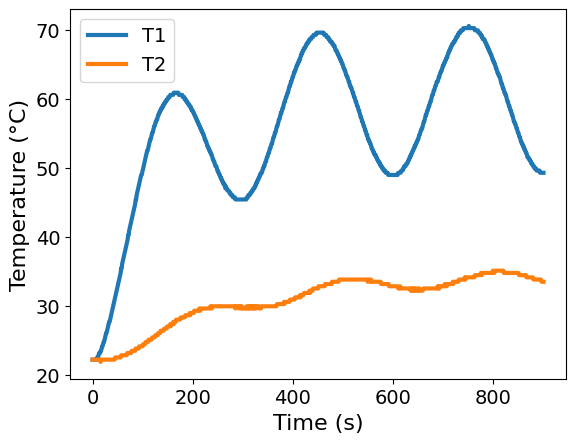

In [3]:
ax = df.plot(x='Time', y=['T1', 'T2'], xlabel='Time (s)', ylabel='Temperature (°C)')

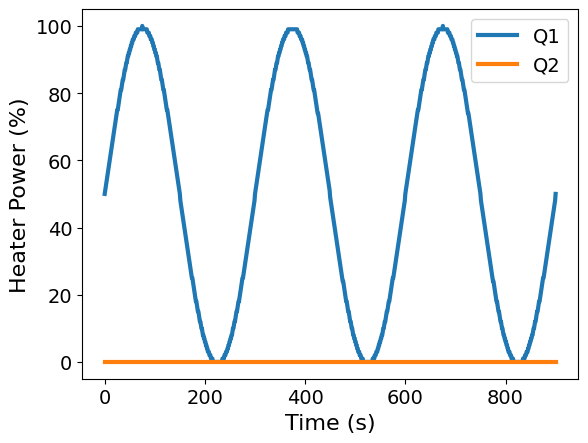

In [4]:
ax = df.plot(x='Time', y=['Q1', 'Q2'], xlabel='Time (s)', ylabel='Heater Power (%)')

## Store in Custom Data Class 

In the file `tclab_pyomo.py`, we defined a `dataclass` for convenience. It is essentially a light weight container to store experimental data.

In [5]:
tc_data = TC_Lab_data(
    name="Sine Wave Test for Heater 1",
    time=df['Time'].values,
    T1=df['T1'].values,
    u1=df['Q1'].values,
    P1=200,
    TS1_data=None,
    T2=df['T2'].values,
    u2=df['Q2'].values,
    P2=200,
    TS2_data=None,
    Tamb=df['T1'].values[0],
)

In [6]:
tc_data.to_data_frame().head()

,time,T1,u1,P1,TS1_data,T2,u2,P2,TS2_data,Tamb
0,0.00,22.2,50,200,None,22.2,0,200,None,22.2
1,1.01,22.2,51,200,None,22.2,0,200,None,22.2
2,2.01,22.2,52,200,None,22.2,0,200,None,22.2
3,3.00,22.2,53,200,None,22.2,0,200,None,22.2
4,4.01,22.2,54,200,None,22.2,0,200,None,22.2


## Parameter Estimation with ParmEst

We seek to solve minimize the sum of residuals squared:

$$
\begin{align*}
\min_{C_p^H, C_p^S, U_a, U_b} \sum_{i \in \mathcal{T}} \left(T_{S}(t_i) - \bar{T}_{S,i} \right)^2
\end{align*}
$$

subject to constraints

$$
\begin{align*}
C_p^H \frac{dT_H}{dt} & = U_a (T_{amb} - T_H) + U_c (T_S - T_H) + \alpha P u(t)\\
C_p^S \frac{dT_S}{dt} & = - U_b (T_S - T_H)  \\
\\
\text{control input data}\qquad u(t_i) & = \bar{u}_{i}, \forall i \in \mathcal{T}
\\
\text{initial condition}\qquad T_H(t_0) & = T_{amb} \\
\text{initial condition}\qquad T_S(t_0) & = T_{amb}
\end{align*}
$$

Here $\bar{T}_{S,i}$ and $\bar{u}_i$ are the measured sensor temperatures and control signals, respectives, at times $i \in \mathcal{T}$. $w$ is a small weight that helps regularize the solution by preventing the model predictions $T_H$ from deviating too much from the measured temperatures.


In the `tclab_pyomo.py` model, we defined several helper functions:
* `extract_results` takes a Pyomo model and returns the results stored in an instance of the `TC_Lab_data` dataclass.
* `extract_plot_results` takes experimental data (stored in a `TC_Lab_data` instance) and a Pyomo model. The function then generates plots showing the data and model predictions.
* `results_summary` summarizes the Pyomo.DoE results. We'll use this later in the workshop.

`parmest` has been refactored to allow users to directly ask for the sum of squared error (SSE) objective. Custom objectives can also be provided, but are outside the scope of this workshop.

In [7]:
import pyomo.contrib.parmest.parmest as parmest

# First, we define an Experiment object within parmest
TC_Lab_sine_exp = TC_Lab_experiment(data=tc_data, number_of_states=number_tclab_states)

# Since everything has been labeled properly in the Experiment object, we simply invoke
# parmest's Estimator function to estimate the parameters.
pest = parmest.Estimator([TC_Lab_sine_exp, ], obj_function='SSE', tee=True)

obj, theta = pest.theta_est()

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

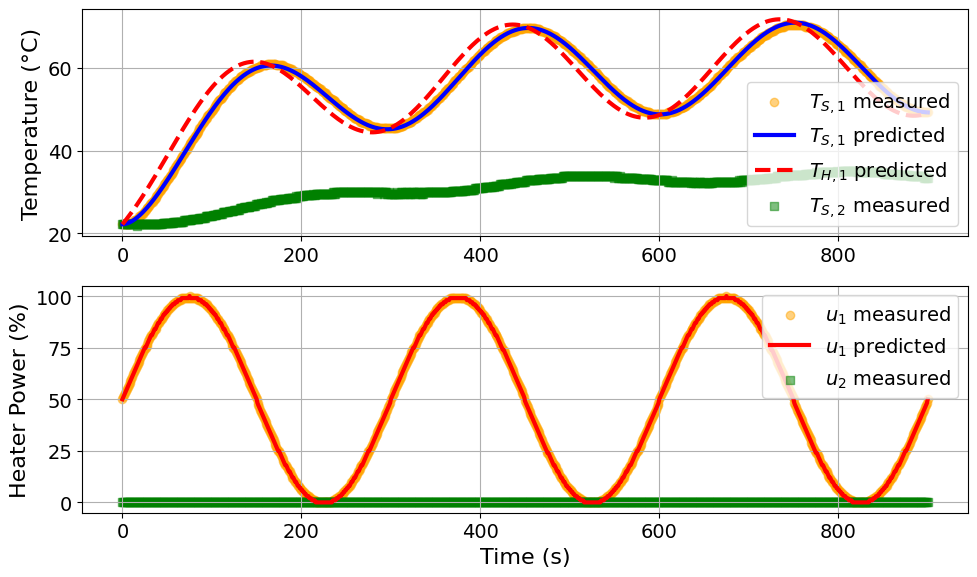

Model parameters:
Ua = 0.0417 Watts/degC
Ub = 0.0094 Watts/degC
CpH = 6.0274 Joules/degC
CpS = 0.1714 Joules/degC
 


In [8]:
parmest_regression_results = extract_plot_results(
    tc_data, pest.ef_instance
)

Let's see how to access the regression results:

In [9]:
theta_values = theta.to_dict()
print("Estimated parameters:\n", theta_values)

Estimated parameters:
 {'Ub': 0.009440714239773074, 'inv_CpS': 5.8357556063605465, 'Ua': 0.0417051733576387, 'inv_CpH': 0.1659093525658045}
